In [ ]:
!pip install catboost

  Using cached graphviz-0.20.3-py3-none-any.whl.metadata (12 kB)
   ---------------------------------------- 0.0/102.4 MB ? eta -:--:--
   - -------------------------------------- 3.7/102.4 MB 21.8 MB/s eta 0:00:05
   - -------------------------------------- 4.5/102.4 MB 11.2 MB/s eta 0:00:09
   --- ------------------------------------ 8.1/102.4 MB 14.4 MB/s eta 0:00:07
   --- ------------------------------------ 9.4/102.4 MB 11.3 MB/s eta 0:00:09
   ---- ----------------------------------- 12.3/102.4 MB 11.7 MB/s eta 0:00:08
   ----- ---------------------------------- 15.2/102.4 MB 12.0 MB/s eta 0:00:08
   ------- -------------------------------- 18.1/102.4 MB 12.1 MB/s eta 0:00:07
   -------- ------------------------------- 21.0/102.4 MB 12.2 MB/s eta 0:00:07
   --------- ------------------------------ 23.6/102.4 MB 12.2 MB/s eta 0:00:07
   ---------- ----------------------------- 26.5/102.4 MB 12.3 MB/s eta 0:00:07
   ----------- ---------------------------- 29.4/102.4 MB 12.4 MB/s 

In [3]:
!pip install xgboost


   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
    --------------------------------------- 2.6/150.0 MB 15.0 MB/s eta 0:00:10
   - -------------------------------------- 6.0/150.0 MB 16.8 MB/s eta 0:00:09
   -- ------------------------------------- 7.6/150.0 MB 13.4 MB/s eta 0:00:11
   --- ------------------------------------ 11.3/150.0 MB 13.3 MB/s eta 0:00:11
   --- ------------------------------------ 14.4/150.0 MB 13.1 MB/s eta 0:00:11
   ---- ----------------------------------- 17.3/150.0 MB 13.1 MB/s eta 0:00:11
   ----- ---------------------------------- 20.2/150.0 MB 13.1 MB/s eta 0:00:10
   ------ --------------------------------- 23.1/150.0 MB 13.1 MB/s eta 0:00:10
   ------ --------------------------------- 26.0/150.0 MB 13.2 MB/s eta 0:00:10
   ------- -------------------------------- 28.6/150.0 MB 13.1 MB/s eta 0:00:10
   -------- ------------------------------- 31.5/150.0 MB 13.1 MB/s eta 0:00:10
   --------- ------------------------------ 34.3/150

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
## modelling
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error,root_mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import warnings
import math

In [6]:
df = pd.read_csv('data/stud1.csv')

In [7]:
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [8]:
df.tail()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
995,female,group E,master's degree,standard,completed,88,99,95
996,male,group C,high school,free/reduced,none,62,55,55
997,female,group C,high school,free/reduced,completed,59,71,65
998,female,group D,some college,standard,completed,68,78,77
999,female,group D,some college,free/reduced,none,77,86,86


## Prepare X and Y Varibale

In [11]:
X = df.drop(columns=['math score'], axis= 1)

In [12]:
X.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,74
1,female,group C,some college,standard,completed,90,88
2,female,group B,master's degree,standard,none,95,93
3,male,group A,associate's degree,free/reduced,none,57,44
4,male,group C,some college,standard,none,78,75


In [13]:
y = df['math score']

In [14]:
y.head()

0    72
1    69
2    90
3    47
4    76
Name: math score, dtype: int64

In [16]:
## create and column transformer with 3 types of transformer
num_features = X.select_dtypes(exclude = 'object').columns
cat_features = X.select_dtypes(include = 'object').columns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer 

numeric_transformer = StandardScaler()
oh_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    [
        ("OneHotEncoder", oh_transformer,cat_features),
        ("StandardScaler", numeric_transformer, num_features)
    ]
)

In [18]:
X = preprocessor.fit_transform(X)

In [19]:
X.shape

(1000, 19)

In [20]:
## Seprarte dataset into train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape

((800, 19), (200, 19))

## Create an evaluation metrics to give all metrics after model training

In [36]:
def evaluate_model(true,predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mse)
    r2 = r2_score(true,predicted)
    return mae,mse,rmse,r2

In [40]:
models = {
    "LinearRegression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "KNeighborsRegressor": KNeighborsRegressor(),
    "DecisionTreeRegressor": DecisionTreeRegressor(),
    "RandomForestRegressor": RandomForestRegressor(),
    "AdaBoostRegressor": AdaBoostRegressor(),
    "CatBoostRegressor": CatBoostRegressor(verbose=0)
}

model_list = []
r2_list = []

for name, model in models.items():
    model.fit(X_train, y_train)

    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Evaluation
    model_train_mae, model_train_mse, model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)
    model_test_mae, model_test_mse, model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)


    print(f"Model: {name}")
    model_list.append(name)

    print("Model performance for training set")
    print(" - ROOT MEAN SQUARE ERROR: {:.4f}".format(model_train_rmse))
    print(" - MEAN ABSOLUTE ERROR: {:.4f}".format(model_train_mae))
    print(" - R2 - SCORE: {:.4f}".format(model_train_r2))

    print("--------------------------")

    print("Model performance for test set")
    print(" - ROOT MEAN SQUARE ERROR: {:.4f}".format(model_test_rmse))
    print(" - MEAN ABSOLUTE ERROR: {:.4f}".format(model_test_mae))
    print(" - R2 - SCORE: {:.4f}".format(model_test_r2))

    r2_list.append(model_test_r2)

    print("=" * 35)
    print("\n")

Model: LinearRegression
Model performance for training set
 - ROOT MEAN SQUARE ERROR: 5.3231
 - MEAN ABSOLUTE ERROR: 4.2667
 - R2 - SCORE: 0.8743
--------------------------
Model performance for test set
 - ROOT MEAN SQUARE ERROR: 5.3940
 - MEAN ABSOLUTE ERROR: 4.2148
 - R2 - SCORE: 0.8804


Model: Lasso
Model performance for training set
 - ROOT MEAN SQUARE ERROR: 6.5938
 - MEAN ABSOLUTE ERROR: 5.2063
 - R2 - SCORE: 0.8071
--------------------------
Model performance for test set
 - ROOT MEAN SQUARE ERROR: 6.5197
 - MEAN ABSOLUTE ERROR: 5.1579
 - R2 - SCORE: 0.8253


Model: Ridge
Model performance for training set
 - ROOT MEAN SQUARE ERROR: 5.3233
 - MEAN ABSOLUTE ERROR: 4.2650
 - R2 - SCORE: 0.8743
--------------------------
Model performance for test set
 - ROOT MEAN SQUARE ERROR: 5.3904
 - MEAN ABSOLUTE ERROR: 4.2111
 - R2 - SCORE: 0.8806


Model: KNeighborsRegressor
Model performance for training set
 - ROOT MEAN SQUARE ERROR: 5.7092
 - MEAN ABSOLUTE ERROR: 4.5180
 - R2 - SCORE: 0

# Results

In [41]:
pd.DataFrame(list(zip(model_list, r2_list)), columns=['Model Name', 'R2_Score']).sort_values(by='R2_Score', ascending=False)


,Model Name,R2_Score
2,Ridge,0.880593
0,LinearRegression,0.880433
5,RandomForestRegressor,0.852414
7,CatBoostRegressor,0.851632
6,AdaBoostRegressor,0.847050
1,Lasso,0.825320
3,KNeighborsRegressor,0.783898
4,DecisionTreeRegressor,0.734053


## Linear Regression


In [42]:
lin_model = LinearRegression(fit_intercept=True)
lin_model = lin_model.fit(X_train,y_train)
y_pred = lin_model.predict(X_test)
score = r2_score(y_test, y_pred) * 100
print("Accuracy of the model is %.2f" %score)

Accuracy of the model is 88.04


## Plot Y_pred and Y_test

Text(0, 0.5, 'Predicted Variable')

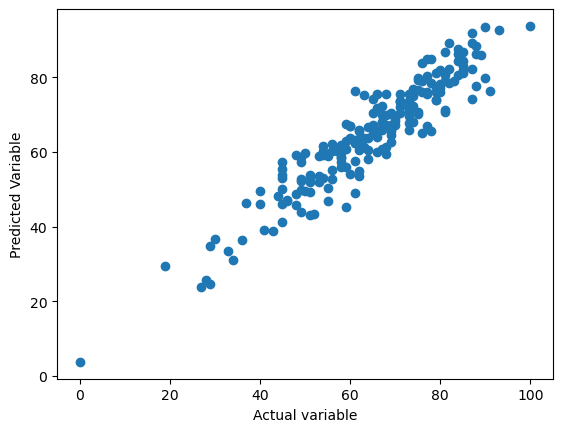

In [43]:
plt.scatter(y_test,y_pred)
plt.xlabel("Actual variable")
plt.ylabel("Predicted Variable")

<Axes: xlabel='math score'>

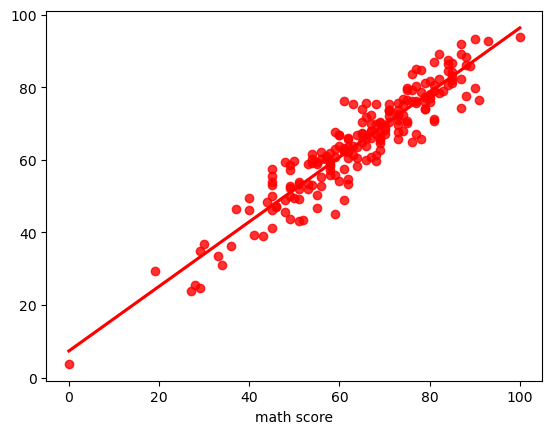

In [45]:
sns.regplot(x=y_test, y = y_pred, ci = None, color = 'red')

## Difference betweeen actual and predictedd values



In [46]:
pred_df = pd.DataFrame({"Actual Value" : y_test, "Predicted Values": y_pred, "Difference": y_test - y_pred})
pred_df

,Actual Value,Predicted Values,Difference
521,91,76.387970,14.612030
737,53,58.885970,-5.885970
740,80,76.990265,3.009735
660,74,76.851804,-2.851804
411,84,87.627378,-3.627378
...,...,...,...
408,52,43.409149,8.590851
332,62,62.152214,-0.152214
208,74,67.888395,6.111605
613,65,67.022287,-2.022287
